In [1]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms.functional as T
from matplotlib import pyplot as plt
from torchvision.utils import draw_segmentation_masks, make_grid
import pytorch_lightning as pl

In [2]:
from inz.data.event import Tier1, Tier3, Test, Hold, Subset, Event
from inz.data.data_module import Event, Hold, Test, Tier1, Tier3, XBDDataModule

In [3]:
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

Seed set to 123


In [17]:
dm1 = XBDDataModule(
    path=Path("data/xBD_processed"),
    events={
        # Tier1: [
        #     Event.hurricane_florence,
        #     Event.hurricane_harvey,
        #     Event.hurricane_matthew,
        #     Event.hurricane_michael,
        # ],
        Tier3: [
            # Event.joplin_tornado,
            Event.moore_tornado,
            # Event.tuscaloosa_tornado
        ],
        # Hold: [
        #     Event.hurricane_florence,
        #     Event.hurricane_harvey,
        #     Event.hurricane_matthew,
        #     Event.hurricane_michael,
        # ],
        # Test: [
        #     Event.hurricane_florence,
        #     Event.hurricane_harvey,
        #     Event.hurricane_matthew,
        #     Event.hurricane_michael,
        # ],
    },
    val_faction=0.15,
    test_fraction=0.0,
    train_batch_size=32,
    val_batch_size=32,
    test_batch_size=32,
)
dm1.prepare_data()
dm1.setup("fit")

def hash_tensor(x: torch.Tensor) -> torch.Tensor:
    return hash(tuple(x.reshape(-1).tolist()))

train_dl = dm1.train_dataloader()
val_dl = dm1.val_dataloader()

train_hashes = [(img * 255).to(torch.int).sum() // 100 for imgs_pre, masks_pre, imgs_post, masks_post in train_dl for img in imgs_pre]
val_hashes = [(img * 255).to(torch.int).sum() // 100 for imgs_pre, masks_pre, imgs_post, masks_post in val_dl for img in imgs_pre]

In [18]:
print(train_hashes)
print(val_hashes)

[tensor(-131077), tensor(-144280), tensor(-120702), tensor(-65894), tensor(-127021), tensor(-144872), tensor(-198017), tensor(-200750), tensor(-271684), tensor(-167033), tensor(-154250), tensor(-232858), tensor(-144865), tensor(-141609), tensor(-126498), tensor(-117394), tensor(-118953), tensor(-114688), tensor(-122336), tensor(-173922), tensor(-125241), tensor(-163340), tensor(-215811), tensor(-125161), tensor(-100068), tensor(-170926), tensor(-64294), tensor(-163226), tensor(-170271), tensor(-203239), tensor(-501351), tensor(-501351), tensor(-181890), tensor(-118147), tensor(-212847), tensor(-167321), tensor(-61341), tensor(-125640), tensor(-109245), tensor(-105845), tensor(-166702), tensor(-83662), tensor(-212275), tensor(-178872), tensor(-41024), tensor(-166277), tensor(-268432), tensor(-152791), tensor(-163607), tensor(-158186), tensor(-208683), tensor(-168957), tensor(-146653), tensor(-501351), tensor(-64102), tensor(-110291), tensor(-146495), tensor(-102776), tensor(-223079), te

In [19]:
assert len(train_hashes) == len(set(train_hashes)), f"{len(train_hashes)}, {len(set(train_hashes))}"
assert len(val_hashes) == len(set(val_hashes)), f"{len(val_hashes)}, {len(set(val_hashes))}"
assert set(train_hashes).intersection(set(val_hashes)) == set(), f"{set(train_hashes).intersection(set(val_hashes))}"

In [6]:
plt.rcParams["savefig.bbox"] = "tight"


def show(imgs: list[torch.Tensor]):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = T.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [7]:
dm = XBDDataModule(
    path=Path("data/xBD_processed"),
    events={
        Tier1: [
            Event.hurricane_harvey,
            Event.santa_rosa_wildfire,
            Event.palu_tsunami,
        ],
        Tier3: list(Tier3.events),
        Hold: list(Hold.events),
        Test: list(Test.events),
    },
    val_faction=0.1,
    test_fraction=0.1,
    train_batch_size=16,
)

In [8]:
dm.prepare_data()
dm.setup("fit")
loader_iter = iter(dm.train_dataloader())

KeyboardInterrupt: 

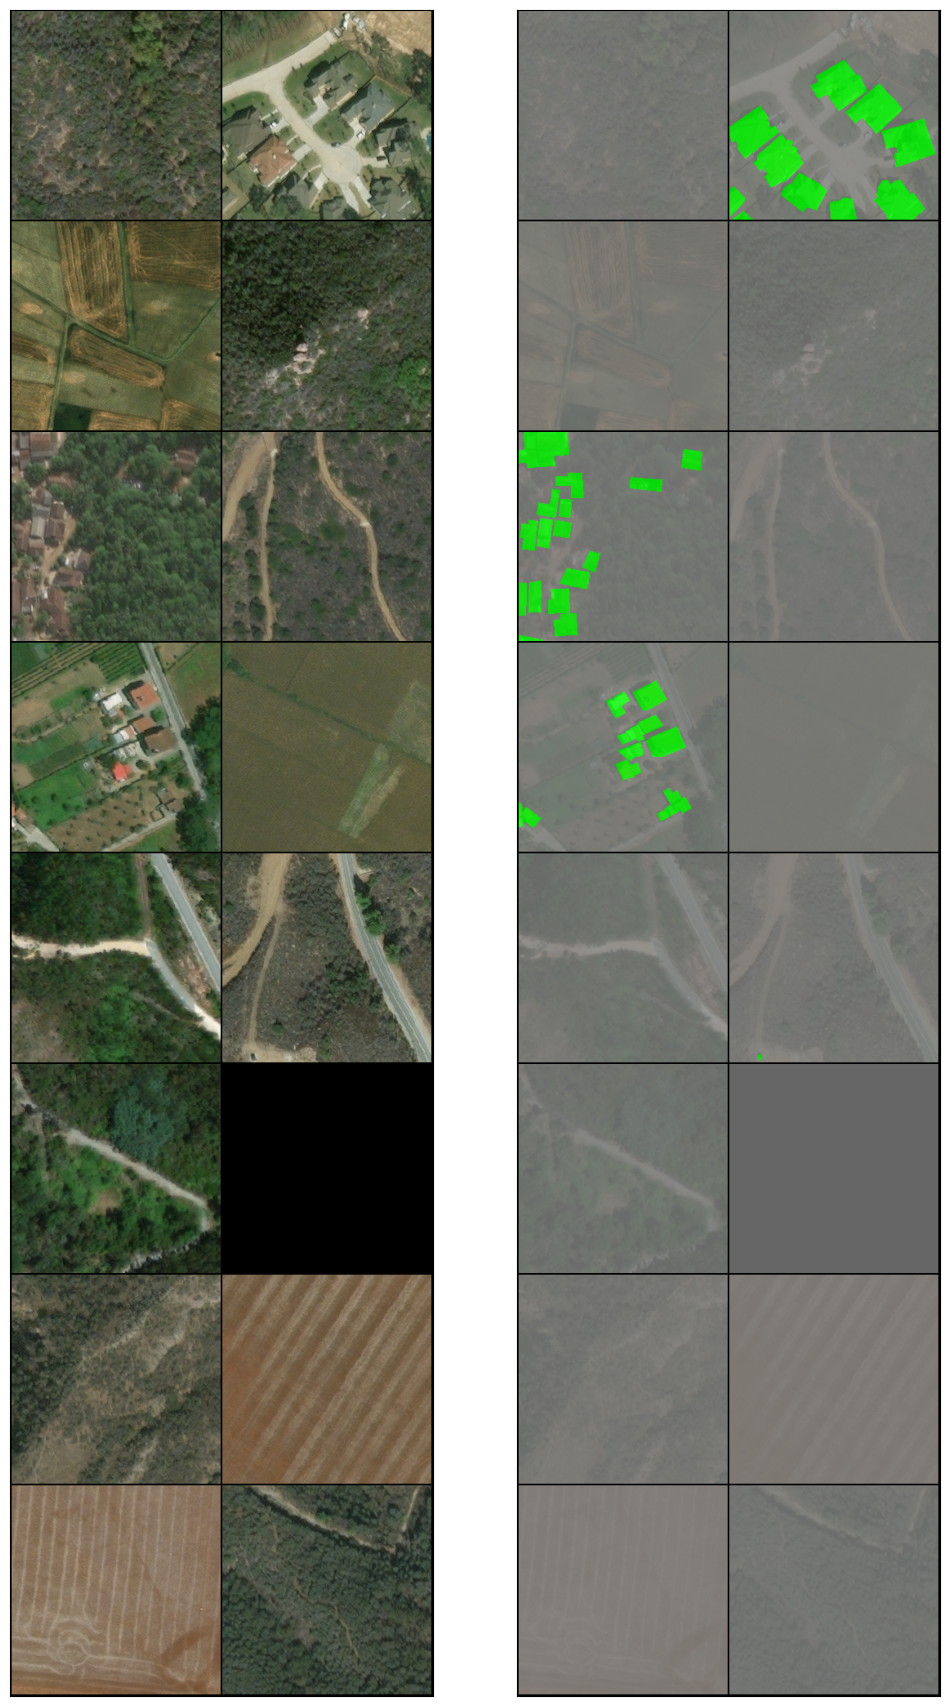

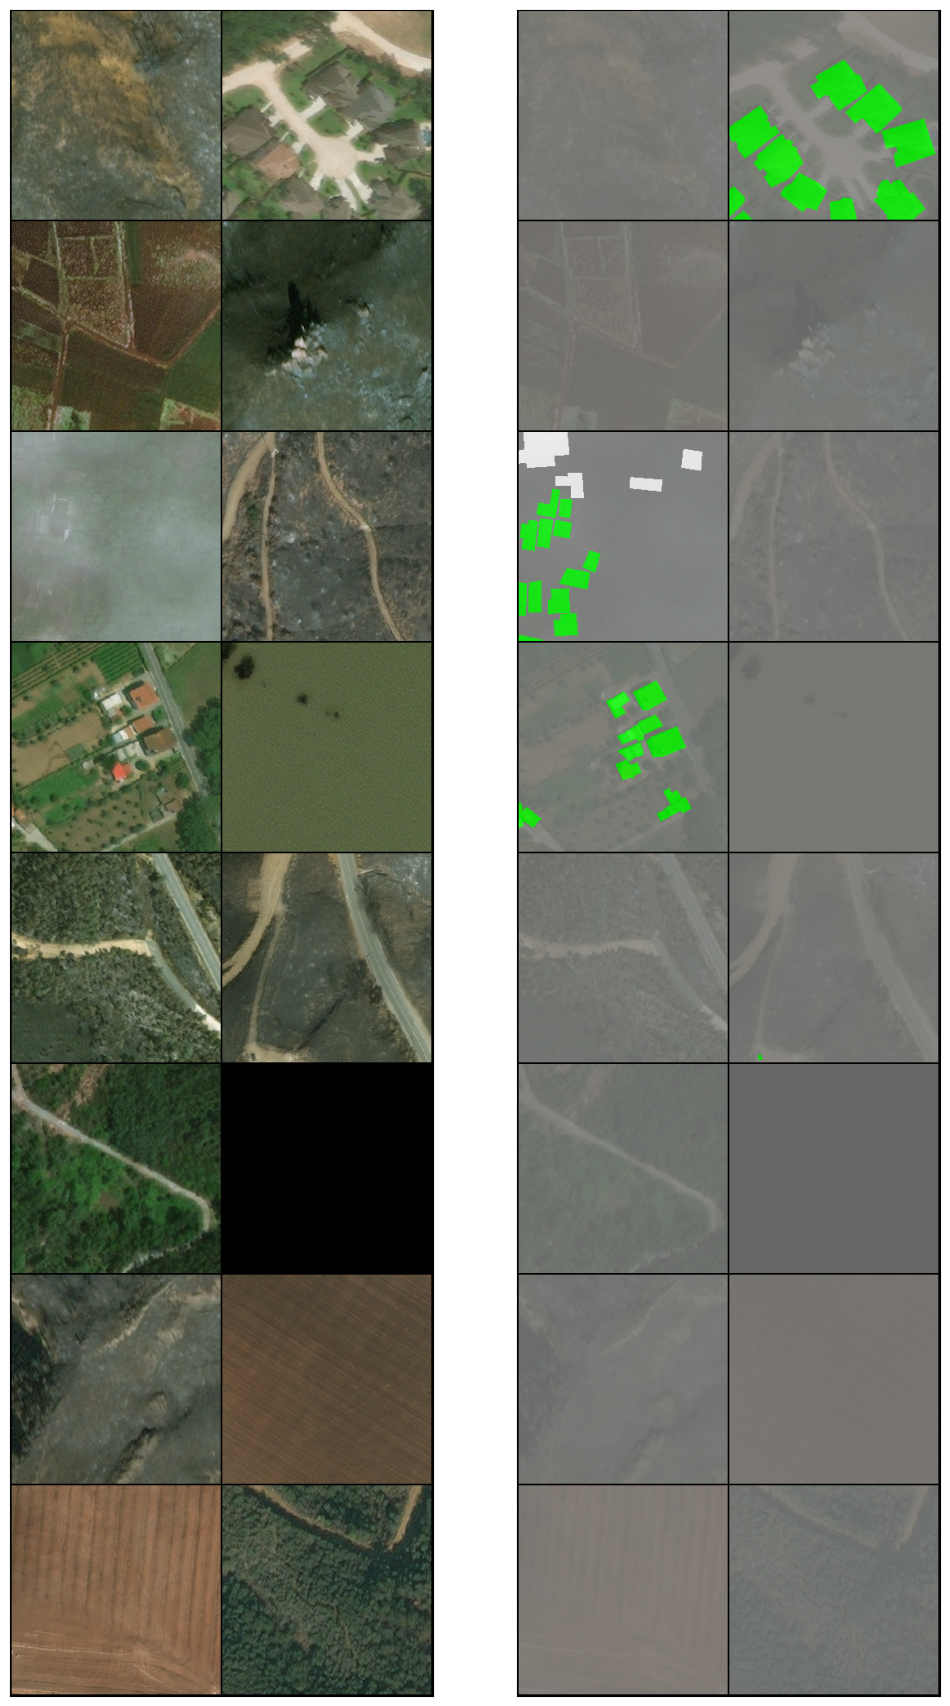

In [ ]:
plt.rcParams["figure.figsize"] = [12, 24]
images_pre, masks_pre, images_post, masks_post = next(iter(loader_iter))
colors = [
    (128, 128, 128),
    (0, 255, 0),
    (244, 255, 0),
    (255, 174, 0),
    (255, 0, 0),
    (255, 255, 255),
]
for images, masks in ((images_pre, masks_pre), (images_post, masks_post)):
    show(
        [
            make_grid((images + 1) / 2, nrow=2),
            make_grid(
                [draw_segmentation_masks(((i + 1) * 127.5).to(torch.uint8), m, colors=colors) for i, m in zip(images, masks.to(torch.bool))], nrow=2
            ),
        ]
    )